In [ ]:
#default_exp display


# Displaying objects in notebooks

This module provides support for displaying objects, such as instance of GTSAM classes.

## Showing graphs
For showing graphs, Graphviz and its python wrapper need to be installed. I did that with `conda install python-graphviz` which also installs graphviz, but these are installed by default on Google's colabs.

In [ ]:
#export
import gtsam
import graphviz
from gtbook.discrete import Variables

Some GTSAM objects have a `dot` method, but notebooks cannot render this. We use a trick, by the following small class, inherting from `graphviz.Source`:

In [ ]:
#export
class show(graphviz.Source):
    """ Display an object with a dot method as a graph."""

    def __init__(self, obj, *args, **kwargs):
        """Construct from object with 'dot' method."""
        # This small class takes an object, calls its dot function, and uses the
        # resulting string to initialize a graphviz.Source instance. This in turn
        # has a _repr_mimebundle_ method, which then renders it in the notebook.
        if args and isinstance(args[0], Variables):
            assert len(args) == 1, "Variables must be only argument."
            keyFormatter = args[0].keyFormatter()
            super().__init__(obj.dot(keyFormatter))
        else:
            super().__init__(obj.dot(*args, **kwargs))

In [ ]:
from gtsam import DiscreteBayesNet
from gtbook.discrete import P

Asia = (0, 2)
Smoking = (1, 2)
Tuberculosis = (2, 2)
LungCancer = (3, 2)
Either = (4, 2)

bayesNet = DiscreteBayesNet()
bayesNet.add(Asia, P(), "99/1")
bayesNet.add(Smoking, P(), "50/50")
bayesNet.add(Tuberculosis, P(Asia), "99/1 95/5")
bayesNet.add(LungCancer, P(Smoking), "99/1 90/10")
bayesNet.add(Either, P(Tuberculosis, LungCancer), "F T T T")

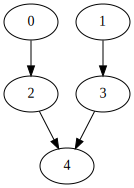

In [ ]:
show(bayesNet)

We can, however, create our own formatter in python, and pass it as an optional argument:

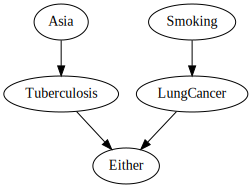

In [ ]:
domain = ["Asia", "Smoking", "Tuberculosis", "LungCancer", "Either"]
keyFormatter = lambda key : domain[key]
show(bayesNet, keyFormatter)

It also works for factor graphs, as illustrated below:

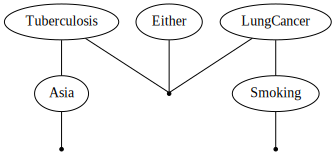

In [ ]:
# convert bayesNet to a factor graph and render:
from gtsam import DiscreteFactorGraph
fg = DiscreteFactorGraph(bayesNet)
show(fg, keyFormatter)

Factor graph graphviz rendering can be customized even more, through a DotWriter object. For example, the following displays the "primamry constraint graph":

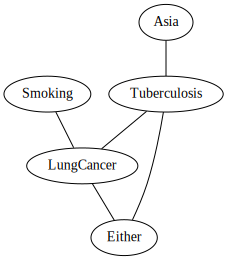

In [ ]:
from gtsam import DotWriter
writer = DotWriter(figureWidthInches=5, figureHeightInches=5,
                   plotFactorPoints=False, binaryEdges=False)
show(fg, keyFormatter, writer)

## Markdown
Markdown can be rendered natively, like so:

In [ ]:
bayesNet

`DiscreteBayesNet` of size 5

 $P(0)$:
|0|value|
|:-:|:-:|
|0|0.99|
|1|0.01|

 $P(1)$:
|1|value|
|:-:|:-:|
|0|0.5|
|1|0.5|

 $P(2|0)$:
|0|0|1|
|:-:|:-:|:-:|
|0|0.99|0.01|
|1|0.95|0.05|

 $P(3|1)$:
|1|0|1|
|:-:|:-:|:-:|
|0|0.99|0.01|
|1|0.9|0.1|

 $P(4|2,3)$:
|2|3|0|1|
|:-:|:-:|:-:|:-:|
|0|0|1|0|
|0|1|0|1|
|1|0|0|1|
|1|1|0|1|



However, to provide optional arguments, we have to resort to a similar trick:

In [ ]:
# export
class pretty:
    """Render an object as markdown with optional arguments."""

    def __init__(self, obj, *args):
        if args and isinstance(args[0], Variables):
            assert len(args) == 1, "Variables must be only argument."
            variables = args[0]
            if isinstance(obj, gtsam.DiscreteValues):
                self._md = variables.values_markdown(obj)
            else:
                self._md = obj._repr_markdown_(variables.keyFormatter())
        else:
            if isinstance(obj, gtsam.DiscreteValues):
                self._md = f"{obj}"
            else:
                self._md = obj._repr_markdown_(*args)

    def _repr_markdown_(self):
        return self._md


In [ ]:
pretty(bayesNet, keyFormatter)

`DiscreteBayesNet` of size 5

 $P(Asia)$:
|Asia|value|
|:-:|:-:|
|0|0.99|
|1|0.01|

 $P(Smoking)$:
|Smoking|value|
|:-:|:-:|
|0|0.5|
|1|0.5|

 $P(Tuberculosis|Asia)$:
|Asia|0|1|
|:-:|:-:|:-:|
|0|0.99|0.01|
|1|0.95|0.05|

 $P(LungCancer|Smoking)$:
|Smoking|0|1|
|:-:|:-:|:-:|
|0|0.99|0.01|
|1|0.9|0.1|

 $P(Either|Tuberculosis,LungCancer)$:
|Tuberculosis|LungCancer|0|1|
|:-:|:-:|:-:|:-:|
|0|0|1|0|
|0|1|0|1|
|1|0|0|1|
|1|1|0|1|



Factor graphs work as well:

In [ ]:
graph = DiscreteFactorGraph()
graph.add(Asia, Smoking, "4 1 10 4")
pretty(graph, keyFormatter)

`DiscreteFactorGraph` of size 1

factor 0:
|Asia|Smoking|value|
|:-:|:-:|:-:|
|0|0|4|
|0|1|1|
|1|0|10|
|1|1|4|



## Domains

We also provide support for the `Variables` data structure:

In [ ]:
variables = Variables()
T = variables.discrete("Tuberculosis", ["No", "Yes"])
L = variables.discrete("LungCancer", ["No", "Yes"])
C = variables.discrete("Either", ["No", "Yes"])

fragment = DiscreteBayesNet()
fragment.add(T, P(), "99/1")
fragment.add(L, P(), "50/50")
fragment.add(C, P(T, L), "F T T T")

In [ ]:
pretty(fragment, variables)

`DiscreteBayesNet` of size 3

 $P(Tuberculosis)$:
|Tuberculosis|value|
|:-:|:-:|
|0|0.99|
|1|0.01|

 $P(LungCancer)$:
|LungCancer|value|
|:-:|:-:|
|0|0.5|
|1|0.5|

 $P(Either|Tuberculosis,LungCancer)$:
|Tuberculosis|LungCancer|0|1|
|:-:|:-:|:-:|:-:|
|0|0|1|0|
|0|1|0|1|
|1|0|0|1|
|1|1|0|1|



In [ ]:
assignment = variables.assignment({C:"Yes"})
assert pretty(assignment)._repr_markdown_() == 'DiscreteValues{2: 1}'
pretty(assignment, variables)

|Variable|Value|
|:-:|:-:|
|Either|Yes|


And of course, showing a graph as well:

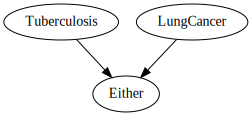

In [ ]:
show(fragment, variables)